# LLM token embeddings

> In this blog post I'll explore the structure of token embeddings in large language models.

- skip_exec: true

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#from transformers import pipeline

In [ ]:
# Doesn't produce any content (probably using incorrectly)
#pipe = pipeline("text-generation", model="nroggendorff/smallama-it")
#pipe = pipeline("text-generation", model="KingNish/Qwen2.5-0.5b-Test-ft")

In [ ]:
#| export
import fastai
import fastai.torch_core
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import gc
import pandas as pd
from fastcore.all import *
from IPython.display import display_markdown

In [ ]:
def clean_memory():
    with torch.no_grad():
        torch.cuda.empty_cache()
    gc.collect()

For our experiments let's grab a small language model. In this case, I will use Qwen2.5-0.5B. It fits in just about 1GB of VRAM, so it's great for experimentation!

In [ ]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

2025-02-23 22:09:50.016171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740377390.037725   21048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740377390.044351   21048 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some parameters are on the meta device because they were offloaded to the cpu.


## Generate text

Even though this model is small, it can still generate coherent text:

In [ ]:
prompt = "Write an introduction for a blog post about large language model token embeddings. Tags: PCA, layer sizes, nearest neighbours, KDTree, singular values."
messages = [
    {"role": "system", "content": "You are an autocorrelating model. You use previous outputs for reasoning. Pay attention to tags."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=2048
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

display_markdown(response, raw=True)

In recent years, the advent of large language models has transformed how we interact with and understand natural language. One critical aspect of these models is their ability to capture complex patterns in vast amounts of text data, which can be challenging to extract directly from raw text. However, traditional approaches often struggle with dimensionality reduction and feature extraction that are essential for understanding the underlying structure of text.

This blog post aims to explore the potential of using Large Language Models (LLMs) to represent and analyze large datasets more effectively by leveraging their powerful token embeddings. Specifically, we will focus on the importance of understanding the underlying representation of LLMs through token embeddings and delve into how Principal Component Analysis (PCA), Layer Sizes, Nearest Neighbors, KD-Trees, and Singular Values can be used to achieve this goal.

We will also discuss the advantages and limitations of using these techniques in practical applications, including applications in information retrieval, sentiment analysis, and more. By understanding the strengths and weaknesses of these methods, we can develop more effective ways to utilize LLMs to improve our understanding of text data.

## LLM Parameters

A large language model is made from an embedding layer, followed by transformer layers. Let's look at their sizes:

In [ ]:
sizes = list(map(lambda x: (np.prod(x.shape), x.shape), model.model.parameters()))
sizes[:10]

[(136134656, torch.Size([151936, 896])),
 (802816, torch.Size([896, 896])),
 (896, torch.Size([896])),
 (114688, torch.Size([128, 896])),
 (128, torch.Size([128])),
 (114688, torch.Size([128, 896])),
 (128, torch.Size([128])),
 (802816, torch.Size([896, 896])),
 (4358144, torch.Size([4864, 896])),
 (4358144, torch.Size([4864, 896]))]

Size of the embedding layer seems to dominate model size for this particular model:

<Axes: >

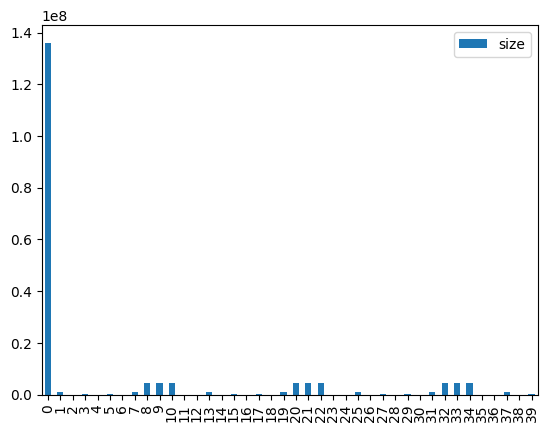

In [ ]:
df = pd.DataFrame(sizes, columns=['size', 'shape'])
df.iloc[:40].plot(y = 'size', kind='bar')

In fact, let's compare size of embeddings with the rest of the model parameters:

In [ ]:
df.loc[0,'size']/df.loc[:, 'size'].sum()

0.275557948415276

So, 28% of the model is in the embeddings.

## PCA

In [ ]:
emb = model.get_input_embeddings()
emb_w = emb.weight
emb_w.shape

torch.Size([151936, 896])

In [ ]:
w = emb_w.cpu().detach()
w = w.type(torch.Tensor)

Numbers, characters, symbols seem to be nicely grouped together:

In [ ]:
w_pca = w.pca(3)

In [ ]:
w_pca.shape

torch.Size([151936, 3])

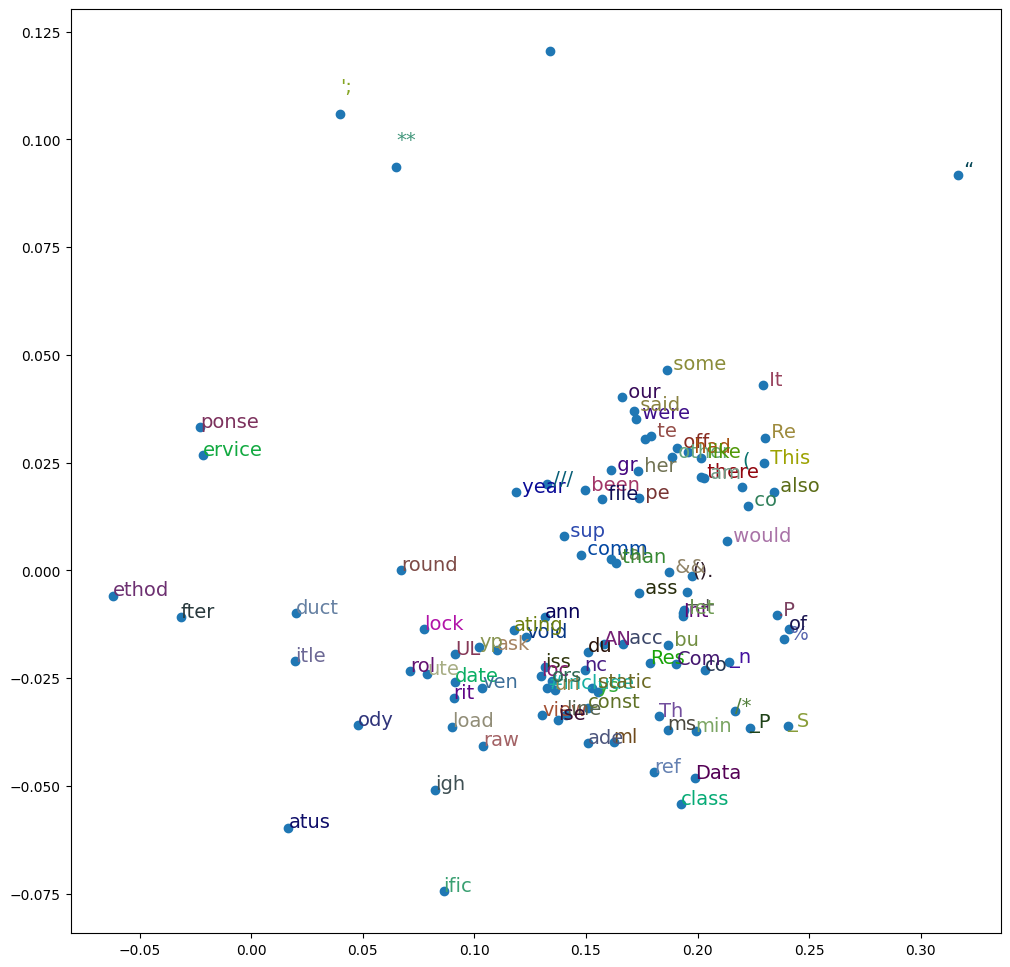

In [ ]:
fac0,fac1,fac2 = w_pca.t()
p = 1000
idxs = list(range(p,p + 100))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
token_labels = [tokenizer.decode([i]) for i in idxs]
for i, x, y in zip(token_labels, X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=14)
#plt.show()
#plt.savefig('token_encodings.png')

## Compare layer sizes

## Understanding token embeddings

In [ ]:
token_labels = L([tokenizer.decode([i]) for i in range(w.shape[0])])
token_labels

(#151936) ['!','"','#','$','%','&',"'",'(',')','*','+',',','-','.','/','0','1','2','3','4'...]

In [ ]:
w.T.shape

torch.Size([896, 151936])

In [ ]:
df = pd.DataFrame(w.T, columns=token_labels)

<matplotlib.image.AxesImage>

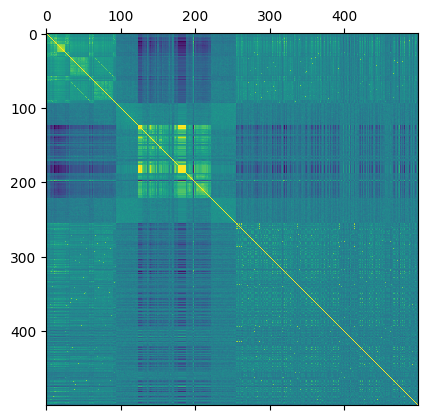

In [ ]:
plt.matshow(df.iloc[:,:500].corr())

In [ ]:
df.iloc[:,124:130].corr()

,�,�,�,�,�,�
�,1.000000,1.000000,0.036561,0.949049,0.999370,0.613330
�,1.000000,1.000000,0.036553,0.949040,0.999370,0.613357
�,0.036561,0.036553,1.000000,0.039240,0.036404,0.066037
�,0.949049,0.949040,0.039240,1.000000,0.948284,0.574783
�,0.999370,0.999370,0.036404,0.948284,1.000000,0.615100
�,0.613330,0.613357,0.066037,0.574783,0.615100,1.000000


<matplotlib.image.AxesImage>

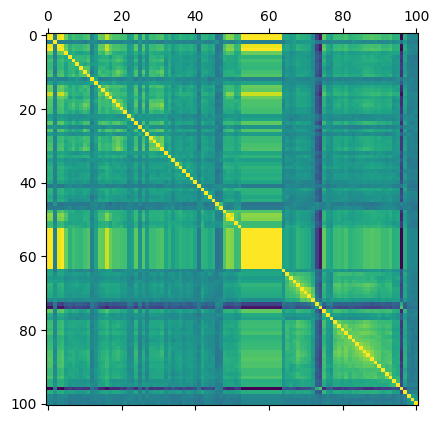

In [ ]:
plt.matshow(df.iloc[:,124:225].corr())

<matplotlib.image.AxesImage>

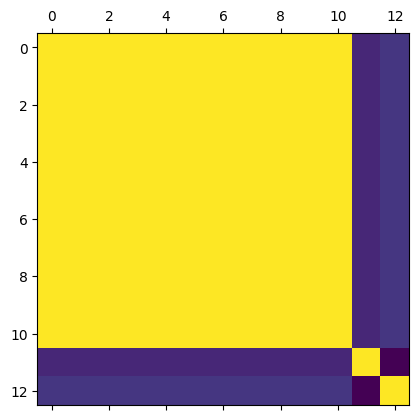

In [ ]:
plt.matshow(df.iloc[:,177:190].corr())

In [ ]:
df = pd.DataFrame(w)

df['token'] = token_labels
df = df.reindex(columns=pd.Index([df.columns[-1]] + list(df.columns[:-1])))

df

,token,0,1,2,3,4,5,6,7,8,...,886,887,888,889,890,891,892,893,894,895
0,!,-0.010376,0.040771,0.009705,0.000070,-0.027100,-0.002975,-0.001160,-0.019531,0.028442,...,-0.008179,0.016724,0.022339,-0.027222,-0.029541,-0.015381,-0.007477,0.009827,0.013611,-0.006683
1,"""",-0.014587,-0.001366,-0.017700,-0.002670,0.003708,-0.001495,0.005402,-0.010620,0.017700,...,-0.013672,-0.038330,0.003433,-0.007355,-0.007172,0.001152,-0.005798,-0.002441,0.002441,-0.008118
2,#,-0.036621,-0.010193,0.007812,-0.010925,0.008057,0.016724,0.023438,-0.030273,-0.009399,...,-0.024048,-0.002716,0.006134,-0.007538,-0.008545,0.008789,0.011292,-0.007355,-0.017700,-0.000675
3,$,-0.009338,-0.012085,-0.015381,0.010864,0.003967,-0.005981,0.005707,-0.006866,0.014343,...,-0.047119,0.007324,0.007935,-0.006531,-0.019897,-0.007812,0.020874,-0.002655,0.015137,-0.017822
4,%,-0.009521,0.004211,0.006012,-0.018433,0.006409,0.013428,0.016846,0.003372,-0.000965,...,0.005798,-0.010742,-0.000957,-0.024170,-0.000463,0.010620,-0.003967,0.003937,-0.006195,-0.007874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151931,,0.005951,-0.005310,0.003326,0.002472,-0.003067,0.002563,-0.009583,0.015747,-0.000580,...,0.003845,0.016113,-0.010071,0.005066,0.011353,0.015320,-0.014954,-0.008179,-0.008179,0.018677
151932,,0.005951,-0.005310,0.003326,0.002472,-0.003067,0.002563,-0.009583,0.015747,-0.000580,...,0.003845,0.016113,-0.010071,0.005066,0.011353,0.015320,-0.014954,-0.008179,-0.008179,0.018677
151933,,0.005951,-0.005310,0.003326,0.002472,-0.003067,0.002563,-0.009583,0.015747,-0.000580,...,0.003845,0.016113,-0.010071,0.005066,0.011353,0.015320,-0.014954,-0.008179,-0.008179,0.018677
151934,,0.005951,-0.005310,0.003326,0.002472,-0.003067,0.002563,-0.009583,0.015747,-0.000580,...,0.003845,0.016113,-0.010071,0.005066,0.011353,0.015320,-0.014954,-0.008179,-0.008179,0.018677


## KDTree

In [ ]:
from scipy.spatial import KDTree

KDTree allows fast nearest neighbour lookups, but it only works fast up to 20 dimensions (according to [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html)).

In [ ]:
w_pca = w.pca(10)

In [ ]:
w_pca.shape

torch.Size([151936, 10])

In [ ]:
m = KDTree(w_pca)

In [ ]:
small_distance = 0.001

m.count_neighbors(m, small_distance)

In [ ]:
neighbours = m.query_pairs(small_distance, output_type='ndarray')

In [ ]:
len(neighbours)

2700502

In [ ]:
w

tensor([[-0.0104,  0.0408,  0.0097,  ...,  0.0098,  0.0136, -0.0067],
        [-0.0146, -0.0014, -0.0177,  ..., -0.0024,  0.0024, -0.0081],
        [-0.0366, -0.0102,  0.0078,  ..., -0.0074, -0.0177, -0.0007],
        ...,
        [ 0.0060, -0.0053,  0.0033,  ..., -0.0082, -0.0082,  0.0187],
        [ 0.0060, -0.0053,  0.0033,  ..., -0.0082, -0.0082,  0.0187],
        [ 0.0060, -0.0053,  0.0033,  ..., -0.0082, -0.0082,  0.0187]])

In [ ]:
first = 100
(w[neighbours[:first,0]] - w[neighbours[:first,1]]).norm(dim=1)

tensor([1.2571e-02, 2.0965e-02, 9.4396e-05, 1.0017e-04, 5.1366e-05, 9.8044e-05,
        6.4521e-05, 1.1918e-04, 1.6839e-04, 8.5407e-05, 8.5055e-05, 8.5661e-05,
        9.6035e-05, 1.1496e-04, 1.8153e-04, 1.0819e-04, 2.3365e-05, 1.1710e-04,
        9.1673e-05, 1.6766e-04, 1.0853e-04, 4.9831e-05, 1.1803e-04, 1.7295e-04,
        1.1530e-04, 9.1910e-05, 1.6751e-04, 1.2525e-04, 1.6791e-04, 1.7944e-04,
        1.6613e-04, 1.6613e-04, 1.6770e-04, 1.8194e-04, 1.6276e-04, 1.6705e-04,
        1.6330e-04, 1.6262e-04, 1.6276e-04, 1.7943e-04, 1.7975e-04, 1.8088e-04,
        1.9296e-04, 1.7631e-04, 1.8060e-04, 1.7582e-04, 1.7519e-04, 1.7532e-04,
        1.6539e-04, 1.6678e-04, 1.6556e-04, 1.8126e-04, 1.6200e-04, 1.6631e-04,
        1.6255e-04, 1.6329e-04, 1.6200e-04, 1.7074e-04, 1.7243e-04, 1.7227e-04,
        1.8616e-04, 1.6746e-04, 1.7197e-04, 1.6834e-04, 1.6906e-04, 1.6781e-04,
        1.6523e-04, 1.6666e-04, 1.6681e-04, 1.8112e-04, 1.6186e-04, 1.6618e-04,
        1.6241e-04, 1.6316e-04, 1.6186e-

In [ ]:
n = 1000000
o = 3000000
list(zip(L(token_labels)[neighbours[o:(o+n), 0]], L(token_labels)[neighbours[o:(o+n), 1]]))

[]

In [ ]:
ts = tokenizer.encode('wet water')
[(t, tokenizer.decode(t)) for t in ts]

[(86, 'w'), (295, 'et'), (3015, ' water')]

In [ ]:
water = 3015
water = w_pca[water]
dist, items = m.query(water, k=20)
L(tokenizer.decode([i]) for i in items)

(#20) [' water',' bit',' access',' turn',' ×',' March',' exact',' target',' page',' different',' file',' defined',' essential',' Thomas',' unit',' count',' status',' functional',' quality',' zero']

Lets now try using all vectors from a sentence

In [ ]:
def find_neighbours(query):
    ts = tokenizer.encode(query)
    v = w_pca[ts].sum(dim=0)
    dist, items = m.query(v, k=20)
    return L(tokenizer.decode([i]) for i in items)

In [ ]:
find_neighbours(' lava')

(#20) [' lava','太阳能','董事会',' stimuli',' fungal',' embody',' daring',' audience',' hazardous',' tumor',' vascular',' damping',' soothing',' qualifies',' addiction','纷纷',' herbal',' melan',' стран','答应']

In [ ]:
find_neighbours(' magma')

(#20) [' magma','事迹','周恩来','蒋介石','あたり','应收账款','规程','秦国',' serotonin','份额',' Jain','長期',' dopamine',' scalp','理财产品',' cereal',' disciplines',' словам','班组',' мероприятия']

In [ ]:
find_neighbours('lava')

(#20) ['l','m','c','d','a','f','A','B','p','9','b','7','x','6','C','8','v','h','s','D']

In [ ]:
find_neighbours('lava fire hot')

(#20) [',','1','2',' (','.','3',':',' ','-','4','0','/',' -','5','6',' "','8',' and','7',' in']

Doesn't seem like there's much structure here!

But here is the structure I was able to find:

In [ ]:
find_neighbours('1')

(#20) ['1','2','3','5','4','0','6','8','7','9','/',':','.','-','(',',','[','_',';',"'"]

In [ ]:
find_neighbours('A')

(#20) ['A','S','B','C','s','D','a','l','i','N','m','M','P','n','d','T','E','I','x','R']

In [ ]:
find_neighbours('$')

(#20) ['$','{','>','%','|','&','//','#','`','}','<','("','^','L','--','I','T','+','::','R']

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()